We use a grid of complex wavenumber values. From the generalized eigenvalue problem for a  given complex wavenumber, we obtain the phase speed, from which we substitute back to get the complex frequency. We then plot the contour of the imaginary part of the complex frequency. This is a test script to check the functionality of the code.


In [464]:
import os 
import sys
m_path = os.getcwd()
sys.path.append(m_path)

# import all required modules:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
#from mpmath import findroot
from scipy.linalg import lu, solve_triangular, eig
from numpy.linalg import cond

from stream_functions import StreamFunctions
from boundary_conditions import BoundaryConditions
from temporal_stability import TemporalStability
from two_equation_solver import *
from claude1 import *

Obtain the dispersion relation

In [465]:

sf = StreamFunctions(n_wakes=1)
bc = BoundaryConditions(sf)
D  = bc.M_non_dim
A = bc.A_non_dim
B = bc.B_non_dim
dispersion_relation = sp.simplify(sp.det(D))

In [466]:
A_dim = bc.A
B_dim = bc.B
print(sp.latex(sp.simplify(A_dim)))
print(sp.latex(sp.simplify(B_dim)))
print(sp.latex(sp.simplify(D)))

\left[\begin{matrix}1 & - e^{- 0.5 \alpha \delta} & - e^{0.5 \alpha \delta} & 0\\0 & e^{0.5 \alpha \delta} & e^{- 0.5 \alpha \delta} & \left(- s - e^{1.0 \alpha \left(D - \delta\right)}\right) e^{- 0.5 \alpha \left(D - \delta\right)}\\- U_{ambient} \alpha \delta \rho_{ambient} & \rho_{ambient} \left(U_{ambient} \alpha \delta + U_{ambient} - U_{wake}\right) e^{- 0.5 \alpha \delta} & \rho_{ambient} \left(- U_{ambient} \alpha \delta + U_{ambient} - U_{wake}\right) e^{0.5 \alpha \delta} & 0\\0 & \rho_{ambient} \left(- U_{ambient} - U_{wake} \alpha \delta + U_{wake}\right) e^{0.5 \alpha \delta} & \rho_{ambient} \left(- U_{ambient} + U_{wake} \alpha \delta + U_{wake}\right) e^{- 0.5 \alpha \delta} & U_{wake} \alpha \delta \rho_{wake} \left(s - e^{1.0 \alpha \left(D - \delta\right)}\right) e^{- 0.5 \alpha \left(D - \delta\right)}\end{matrix}\right]
\left[\begin{matrix}0 & 0 & 0 & 0\\0 & 0 & 0 & 0\\- \alpha \delta \rho_{ambient} & \alpha \delta \rho_{ambient} e^{- 0.5 \alpha \delta} & - \alpha

In [467]:
print('A_non_dim')
print(sp.latex(A))
print('B_non_dim')
print(sp.latex(B))

A_non_dim
\left[\begin{matrix}1 & - e^{- 0.5 \alpha \delta} & - e^{0.5 \alpha \delta} & 0\\0 & e^{0.5 \alpha \delta} & e^{- 0.5 \alpha \delta} & - s e^{- \alpha \left(0.5 - 0.5 \delta\right)} - e^{\alpha \left(0.5 - 0.5 \delta\right)}\\- \alpha \delta \left(1 - \Lambda\right) & - \delta \left(\frac{2 \Lambda e^{- 0.5 \alpha \delta}}{\delta} - \alpha \left(1 - \Lambda\right) e^{- 0.5 \alpha \delta}\right) & - \delta \left(\frac{2 \Lambda e^{0.5 \alpha \delta}}{\delta} + \alpha \left(1 - \Lambda\right) e^{0.5 \alpha \delta}\right) & 0\\0 & \delta \left(\frac{2 \Lambda e^{0.5 \alpha \delta}}{\delta} - \alpha \left(\Lambda + 1\right) e^{0.5 \alpha \delta}\right) & \delta \left(\frac{2 \Lambda e^{- 0.5 \alpha \delta}}{\delta} + \alpha \left(\Lambda + 1\right) e^{- 0.5 \alpha \delta}\right) & - S \delta \left(\Lambda + 1\right) \left(- \alpha s e^{- \alpha \left(0.5 - 0.5 \delta\right)} + \alpha e^{\alpha \left(0.5 - 0.5 \delta\right)}\right)\end{matrix}\right]
B_non_dim
\left[\begin{matrix}

Substitute the desired values

In [468]:
#val_set = {'S': 0.2, 'Lambda': -3.1, 'delta': 0.1, 's':-1, 'c': f'{sf.w}/{sf.alpha}'}
#val_set = {'S': 1.0, 'Lambda': -3.1, 'L': 0.0, 'delta': 0.1, 's':-1}
val_set = {'S': 0.1, 'Lambda': 0.5, 'L': 0.0, 'delta': 0.1, 's':-1}
#val_set = {'S': 1, 'Lambda': 0.9, 'L': 0.0, 'delta': 0.5, 's':1}
A_sub = A.subs(val_set)
B_sub = B.subs(val_set)
dispersion_relation_sub = dispersion_relation.subs(val_set)

Form the derivative of the determinant equals $0$ equation

In [469]:
deriv_disp = sp.diff(dispersion_relation_sub, sf.alpha)
print(sp.latex(deriv_disp))

1.4 \left(- 0.5 \left(- 0.11 \alpha c + 0.165 \alpha + 1.0\right) e^{- 1.25 \alpha} + 0.5 \left(- 0.09 \alpha c + 0.135 \alpha + 1.0\right) e^{- 0.35 \alpha} - \left(0.009 \alpha^{2} c^{2} - 0.018 \alpha^{2} c + 0.00675 \alpha^{2} + 0.055 \alpha c + 0.0175 \alpha - 0.5\right) e^{- 1.05 \alpha} + \left(0.011 \alpha^{2} c^{2} - 0.022 \alpha^{2} c + 0.00825 \alpha^{2} + 0.045 \alpha c + 0.0325 \alpha - 0.5\right) e^{- 0.15 \alpha}\right) e^{0.7 \alpha} + 2 \left(0.5 \left(0.135 - 0.09 c\right) e^{- 0.35 \alpha} - 0.5 \left(0.165 - 0.11 c\right) e^{- 1.25 \alpha} + 0.625 \left(- 0.11 \alpha c + 0.165 \alpha + 1.0\right) e^{- 1.25 \alpha} - 0.175 \left(- 0.09 \alpha c + 0.135 \alpha + 1.0\right) e^{- 0.35 \alpha} - \left(0.018 \alpha c^{2} - 0.036 \alpha c + 0.0135 \alpha + 0.055 c + 0.0175\right) e^{- 1.05 \alpha} + \left(0.022 \alpha c^{2} - 0.044 \alpha c + 0.0165 \alpha + 0.045 c + 0.0325\right) e^{- 0.15 \alpha} + 1.05 \left(0.009 \alpha^{2} c^{2} - 0.018 \alpha^{2} c + 0.00675 \alpha^

Solve the generalized eigenvalue problem to obtain value for c for a grid of phase_speed $c$ values

In [480]:
ts = TemporalStability(sf, bc, val_set)
max_threshold = 1e6
#alpha_r = np.arange(0,20.01,0.5)
#alpha_i = np.arange(-20,20,0.5)
alpha_r = np.arange(0,0.5,0.01)
alpha_i = np.arange(-1.5,0.5,0.01)
alpha_R, alpha_I = np.meshgrid(alpha_r, alpha_i)
alpha = alpha_R + 1j * alpha_I
w_vals_imag = np.zeros_like(alpha_I)
w_vals = np.zeros_like(alpha)

for i in range(alpha.shape[0]):
    print(f'Row {i+1} of {alpha.shape[0]}')
    for j in range(alpha.shape[1]):
        alpha_val = alpha[i,j]
        c_val_list, eigvecs = ts.find_c(alpha_val)
        temp_w_vals = c_val_list * alpha_val
        temp_w_vals[np.isnan(np.abs(temp_w_vals))] = -1e10-1j*1e10
        temp_w_vals[np.isinf(np.abs(temp_w_vals))] = -1e10-1j*1e10
        temp_w_vals[np.abs(temp_w_vals) > max_threshold] = -1e10-1j*1e10
        temp_w_vals = temp_w_vals[temp_w_vals != 0 + 0j]
        if len(temp_w_vals) == 0:
            temp_max_w_val_imag = np.array([0.0])
        else:
            temp_max_w_val_imag = np.max(np.imag(temp_w_vals)) 
        max_w_val_idx = np.argmax(np.imag(temp_w_vals))
        w_vals[i,j] = temp_w_vals[max_w_val_idx]
        w_vals_imag[i,j] = np.imag(w_vals[i,j])

Row 1 of 200


C:\Users\tvivek\AppData\Local\Temp\ipykernel_18488\3048568538.py:17: RuntimeWarning: invalid value encountered in multiply
  temp_w_vals = c_val_list * alpha_val


Row 2 of 200
Row 3 of 200
Row 4 of 200
Row 5 of 200
Row 6 of 200
Row 7 of 200
Row 8 of 200
Row 9 of 200
Row 10 of 200
Row 11 of 200
Row 12 of 200
Row 13 of 200
Row 14 of 200
Row 15 of 200
Row 16 of 200
Row 17 of 200
Row 18 of 200
Row 19 of 200
Row 20 of 200
Row 21 of 200
Row 22 of 200
Row 23 of 200
Row 24 of 200
Row 25 of 200
Row 26 of 200
Row 27 of 200
Row 28 of 200
Row 29 of 200
Row 30 of 200
Row 31 of 200
Row 32 of 200
Row 33 of 200
Row 34 of 200
Row 35 of 200
Row 36 of 200
Row 37 of 200
Row 38 of 200
Row 39 of 200
Row 40 of 200
Row 41 of 200
Row 42 of 200
Row 43 of 200
Row 44 of 200
Row 45 of 200
Row 46 of 200
Row 47 of 200
Row 48 of 200
Row 49 of 200
Row 50 of 200
Row 51 of 200
Row 52 of 200
Row 53 of 200
Row 54 of 200
Row 55 of 200
Row 56 of 200
Row 57 of 200
Row 58 of 200
Row 59 of 200
Row 60 of 200
Row 61 of 200
Row 62 of 200
Row 63 of 200
Row 64 of 200
Row 65 of 200
Row 66 of 200
Row 67 of 200
Row 68 of 200
Row 69 of 200
Row 70 of 200
Row 71 of 200
Row 72 of 200
Row 73 of 200


In [481]:
c_val_list
w_vals_imag

array([[-0.46971228, -0.47305494, -0.47633804, ..., -0.56293691,
        -0.56363348, -0.56428547],
       [-0.46453131, -0.46782467, -0.47105927, ..., -0.55633299,
        -0.55701506, -0.55765296],
       [-0.45940872, -0.46265315, -0.4658396 , ..., -0.54977387,
        -0.55044083, -0.55106401],
       ...,
       [ 0.41887895,  0.42062448,  0.42240165, ...,  0.52855876,
         0.53131544,  0.53408207],
       [ 0.42630317,  0.4280376 ,  0.42980313, ...,  0.53519775,
         0.53794   ,  0.54069254],
       [ 0.43369618,  0.43541963,  0.43717366, ...,  0.5418261 ,
         0.54455426,  0.54729305]], shape=(200, 50))

Contour field plot of $\max(w_{i})$ on the complex frequency plane

0.5472930505339416
-0.5642854666114298
0.6707353514066158
-0.09539600729536958


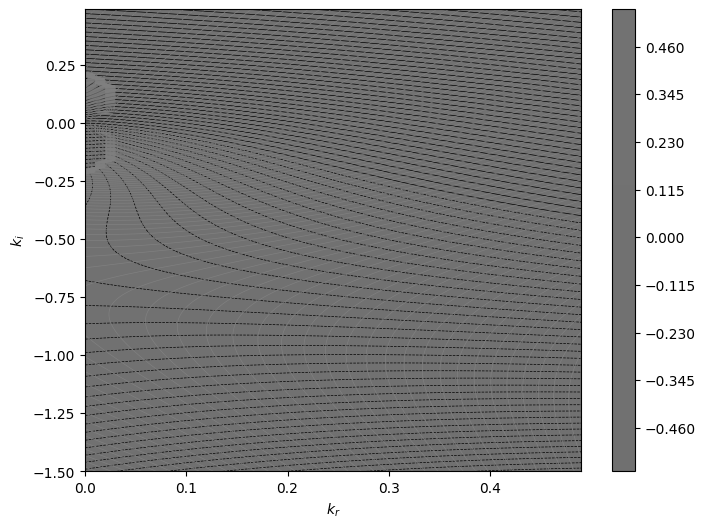

In [482]:
#plt.close()
#w_vals[np.imag(w_vals) < max_threshold] = 0
w_vals[w_vals < -1e6] = 0
print(np.max(np.imag(w_vals)))
print(np.min(np.imag(w_vals)))
print(np.max(np.real(w_vals)))
print(np.min(np.real(w_vals)))
fig, ax = plt.subplots(figsize=(8, 6))
cs = ax.contourf(alpha_R, alpha_I, np.imag(w_vals), levels=250)
cbar = plt.colorbar(cs)
cs.set_clim(-64, 80)
ax.contour(alpha_R, alpha_I, np.imag(w_vals), levels=100, colors='black', linewidths=0.5)
ax.contour(alpha_R, alpha_I, np.real(w_vals), levels=100, colors='gray', linewidths=0.5)
# set colormap to jet
cs.set_cmap('gray')
ax.set_xlabel('$k_r$')
ax.set_ylabel('$k_i$')
#ax.set_xlim(0, 4)
#ax.set_ylim(-4, 4)
plt.ion()
plt.show()

In [473]:
w_vals

array([[  7.0552648 -13.18641925j,   6.82650545-12.63999882j,
          6.68611956-12.43310392j, ...,  14.49237526-10.14304275j,
         14.74121355-10.1300634j ,  14.99034331-10.11817532j],
       [  6.43184061-13.1817812j ,   6.46812308-12.73578598j,
          6.48778036-12.43694963j, ...,  14.47866924 -9.89376905j,
         14.72866206 -9.88052001j,  14.97886146 -9.86840223j],
       [  5.9699784 -13.0510722j ,   6.1091577 -12.66466571j,
          6.22629558-12.35452299j, ...,  14.46471779 -9.6432755j ,
         14.71590466 -9.62984618j,  14.96720923 -9.61758311j],
       ...,
       [-14.49944183+27.71125892j, -12.88009528+27.54730632j,
        -11.42094578+27.36094657j, ...,  19.38086055+27.6569658j ,
         20.13583137+27.66586766j,  20.89007432+27.67401256j],
       [-14.29299563+29.45179021j, -12.60173065+29.10089842j,
        -11.156761  +28.72121413j, ...,  19.37198628+28.41271983j,
         20.12768793+28.42082048j,  20.88261635+28.42826197j],
       [-13.87794594+31.3726

Find the minimum absolute value of $\partial D/\partial k$:

In [474]:
#print(w_vals_imag.shape)
#print(alpha.shape)
#deriv_vals = np.zeros_like(alpha)
#deriv_val_set = {'c': f'{sf.w}/{sf.alpha}'}
#deriv_disp_sub1 = deriv_disp.subs(deriv_val_set)
#for i in range(alpha.shape[0]):
#    print(f'Row {i+1} of {alpha.shape[0]}')
#    for j in range(alpha.shape[1]):
#        deriv_disp_sub2 = deriv_disp_sub1.subs({sf.alpha: alpha[i,j], sf.w: w_vals[i,j]})
#        deriv_vals[i,j] = deriv_disp_sub2.evalf()

In [475]:
#fig, ax = plt.subplots(figsize=(8, 6))
#cs = ax.contourf(alpha_R, alpha_I, np.abs(deriv_vals), levels=250)
#cbar = plt.colorbar(cs)
#cs.set_clim(0, 8)
#ax.contour(alpha_R, alpha_I, np.abs(deriv_vals), levels=100, colors='black', linewidths=0.5)
## set colormap to jet
#cs.set_cmap('gray')
#ax.set_xlabel('$k_r$')
#ax.set_ylabel('$k_i$')
#ax.set_xlim(0, 3.5)
#ax.set_ylim(-4, 4)
#plt.ion()
#plt.show()

In [476]:
#res_i, res_j = np.unravel_index(np.argmin(np.abs(deriv_vals)), deriv_vals.shape)
#print(f'{res_i}, {res_j}')
#print(alpha_R[res_i, res_j])
#print(alpha_I[res_i, res_j])
#print(deriv_vals[res_i, res_j])
#print(abs(deriv_vals[res_i, res_j]))

In [483]:
# save data as mat file
import scipy.io as sio
sio.savemat('C:\\Users\\tvivek\\Desktop\\w_vals_imag.mat', {'w_vals': w_vals, 'alpha_R': alpha_R, 'alpha_I': alpha_I})

In [478]:
from matplotlib.widgets import Cursor
# Add cursor for better pointing
cursor = Cursor(ax, useblit=True, color='red', linewidth=1)

# Create annotation that will show the value
annot = ax.annotate("", xy=(0,0), xytext=(20,20), 
                   textcoords="offset points",
                   bbox=dict(boxstyle="round", fc="w"),
                   arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def onclick(event):
    if event.inaxes != ax:
        return
    
    # Hide previous annotation
    annot.set_visible(False)
    
    # Get clicked coordinates
    x_click, y_click = event.xdata, event.ydata
    
    # Find closest data point (since we can't interpolate from contour directly)
    idx_x = np.argmin(np.abs(x - x_click))
    idx_y = np.argmin(np.abs(y - y_click))
    z_value = Z[idx_y, idx_x]  # Note y comes first in 2D arrays
    
    # Update annotation
    annot.xy = (x_click, y_click)
    annot.set_text(f"Value: {z_value:.3f}")
    annot.set_visible(True)
    
    # Mark the clicked point
    if hasattr(onclick, 'marker'):
        onclick.marker.remove()
    onclick.marker = ax.plot(x_click, y_click, 'ro')[0]
    
    fig.canvas.draw_idle()

# Connect the click event
fig.canvas.mpl_connect('button_press_event', onclick)
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

The biggest problem that I'm facing right now is the uncertainty of not knowing whether the dispersion relation that I have is actually correct or wrong. That can be partially (I think 80%) rectified if I'm able to match the existing results of temporal stability from literature with the result that I'm getting with the dispersion relation that I derived. So here we do exactly that: 

In [479]:
alpha_r_ts = np.arange(0.01, 8.01, 0.25)
c_vals = []
for alpha_val in alpha_r_ts:
    c_val_list = ts.find_c(alpha_val)
    c_val_list[np.isinf(np.abs(c_val_list))] = -1000000000
    c_vals.append(np.max(np.imag(c_val_list)))

c_vals = np.array(c_vals)
w_vals = c_vals * alpha_r_ts

plt.ion()
plt.figure()
#plt.plot(x_D, w0i, color='blue', linestyle='--')
plt.plot(alpha_r_ts, w_vals, color='blue')
plt.scatter(alpha_r_ts, w_vals, color='blue', marker='x', s=50, label='Varicose mode')
plt.xlabel('$k_r$')
plt.ylabel('$\omega_i$')

<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
C:\Users\tvivek\AppData\Local\Temp\ipykernel_18488\2256976604.py:17: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$\omega_i$')


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 4) + inhomogeneous part.

In [ ]:
np.logspace(-1,1,13)

array([ 0.1       ,  0.14677993,  0.21544347,  0.31622777,  0.46415888,
        0.68129207,  1.        ,  1.46779927,  2.15443469,  3.16227766,
        4.64158883,  6.81292069, 10.        ])